In [3]:
from utils import Classes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

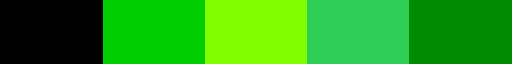

In [4]:
cmap = ListedColormap(
    np.array(
        [
            [[0.0, 0.0, 0.0]],
            [[0.0, 0.80392157, 0.0]],
            [[0.49803922, 1.0, 0.0]],
            [[0.18039216, 0.80392157, 0.34117647]],
            [[0.0, 0.54509804, 0.0]],
        ]
    )
)
cmap

In [5]:
def display(img, cmap="gray"):
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap=cmap)

In [71]:
def ndvi_index_get(hsi):
    red = hsi[:, :, 59]
    nir = (hsi[:, :, 96] + hsi[:, :, 97]) / 2
    ndvi = (nir - red) / (nir + red + 1e-9)
    return ndvi


def ndvi_mask_get(hsi, threshold=0):
    return ndvi_index_get(hsi) > threshold

In [72]:
def savi_index_get(hsi):
    red = hsi[:, :, 59]
    nir = (hsi[:, :, 96] + hsi[:, :, 97]) / 2
    return (1.5 * (nir - red)) / (nir + red + 0.5 + 1e-9)


def savi_mask_get(hsi, threshold=0):
    return savi_index_get(hsi) > threshold

In [73]:
hsi = np.load("data/hyperspectral.npy")
groundtruth = np.load("groundtruth/groundtruth.npy")
lidar = np.load("data/lidar.npy")

In [74]:
mask_vegetation = ndvi_mask_get(hsi) | savi_mask_get(hsi)
mask_vegetation.shape, np.sum(mask_vegetation)

((349, 1905), 257173)

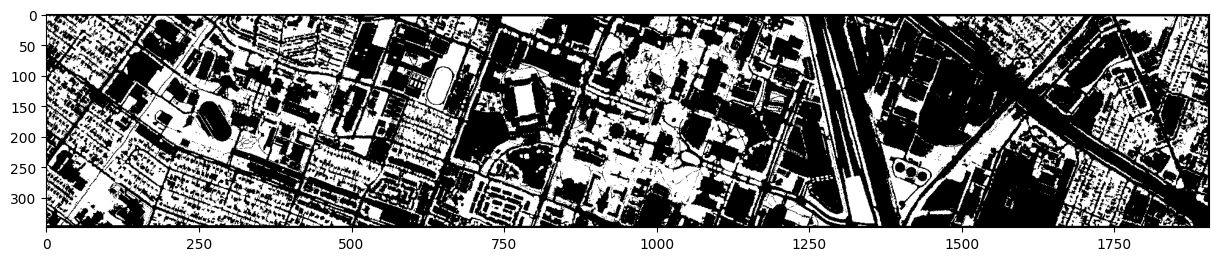

In [75]:
display(mask_vegetation)

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [15]:
classes_vegetation = [
    Classes.GRASS_HEALTHY,
    Classes.GRASS_STRESSED,
    Classes.GRASS_SYNTHETIC,
    Classes.TREE,
]

In [16]:
hsi_reshaped = hsi.reshape(-1, hsi.shape[-1])
groundtruth_reshaped = groundtruth.reshape(-1)
lidar_reshaped = lidar.reshape(-1)

In [67]:
features = np.hstack((hsi_reshaped, lidar_reshaped.reshape(-1, 1)))
features.shape

(664845, 145)

In [58]:
__ii = np.isin(groundtruth_reshaped, classes_vegetation)
X = features[__ii]
y = groundtruth_reshaped[__ii]
X.shape, y.shape

((768, 145), (768,))

In [59]:
np.unique(y, return_counts=True)

(array([1, 2, 3, 4], dtype=uint8), array([198, 190, 192, 188]))

In [60]:
sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
train_idx, test_idx = next(sss.split(X, y))
X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

In [61]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([1, 2, 3, 4], dtype=uint8), array([158, 152, 154, 150])),
 (array([1, 2, 3, 4], dtype=uint8), array([40, 38, 38, 38])))

In [62]:
model = make_pipeline(
    StandardScaler(),
    SGDClassifier(
        random_state=42,
        shuffle=False,
        early_stopping=True,
        n_jobs=4,
    ),
)

In [63]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(early_stopping=True, n_jobs=4, random_state=42,
                               shuffle=False))])

In [64]:
model.score(X_test, y_test)

1.0

In [78]:
features_vegetation = features[mask_vegetation.reshape(-1)]
features_vegetation.shape, features.shape

((257173, 145), (664845, 145))

In [80]:
y_pred = model.predict(features_vegetation)
y_pred.shape

(257173,)

In [81]:
np.unique(y_pred, return_counts=True)

(array([1, 2, 3, 4], dtype=uint8), array([55792, 84776, 47208, 69397]))

In [84]:
img_pred = np.zeros(lidar.shape)
img_pred[mask_vegetation] = y_pred
img_pred.shape, np.unique(img_pred, return_counts=True)

((349, 1905),
 (array([0., 1., 2., 3., 4.]),
  array([407672,  55792,  84776,  47208,  69397])))

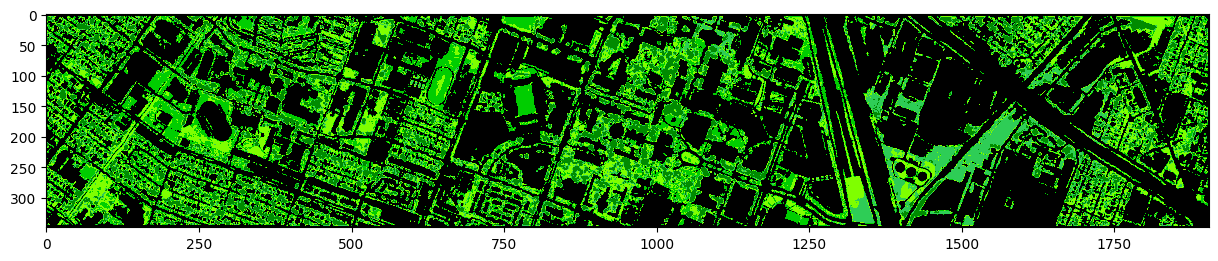

In [83]:
display(img_pred, cmap)